# Valores perdidos


Un problema habitual suele consistir en la presencia de datos ausentes o valores perdidos.

Es importante tener claro cómo leer los datos indicando la posible ausencia de
valor, usando *na_values*:

In [1]:
from pandas import read_csv
import pandas as pd

data = pd.read_csv("nulos.csv", na_values=['?', '', 'NA'])
data.isnull().sum()

nombre        0
edad          1
color_pelo    2
ciudad        0
dtype: int64

---

Hay múltiples técnicas para tratar los datos perdidos. Es importante valorar si la
técnica de aprendizaje es capaz de trabajar con datos perdidos o no.

Para conocer los nulos (en porcentaje):

In [2]:
ratio_nulos = data.isnull().sum()/data.shape[0]
ratio_nulos

nombre        0.00
edad          0.25
color_pelo    0.50
ciudad        0.00
dtype: float64

## Opción directa (eliminar nulos)

Se pueden eliminar o bien los atributos que tienen demasiados nulos, o eliminar
tuplas.

Eliminar atributos que superen un umbral:

In [3]:
data2 = data.copy()

for i, atrib in enumerate(data):
    if ratio_nulos[i] > 0.4:
        data2.drop(atrib, axis=1, inplace=True)

print(data2)

     nombre  edad   ciudad
0    Daniel   NaN  Granada
1      Luis  46.0  Granada
2      Ivan  39.0    Cadiz
3  Virginia  41.0    Paris


C:\Users\julian\AppData\Local\Temp\ipykernel_7924\1999010102.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ratio_nulos[i] > 0.4:
C:\Users\julian\AppData\Local\Temp\ipykernel_7924\1999010102.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ratio_nulos[i] > 0.4:


---

Eliminar todas las filas con algún nulo

In [4]:
data_drop = data.dropna()
print(data_drop)

     nombre  edad color_pelo ciudad
3  Virginia  41.0      negro  Paris


In [5]:
data_drop = data2.dropna()
print(data_drop)

     nombre  edad   ciudad
1      Luis  46.0  Granada
2      Ivan  39.0    Cadiz
3  Virginia  41.0    Paris


## Tratar valores perdidos con paquetes externos

Dado que los métodos de aprendizaje en `scikit-learn` no son compatibles en su mayoría con valores perdidos,
vamos a probar distintas opciones que la propia librería nos permite.

In [6]:
#| echo: false
import pandas as pd
import numpy as np
from sklearn import datasets
iris_dataset = datasets.load_iris(as_frame=True)
X_iris = iris_dataset.data.copy()

Para probar los métodos añadidos nulos al dataset:

In [7]:
#Prepare the dataset to test sk-learn imputation values tools
np.random.seed(42)
rows = np.random.randint(0, np.shape(X_iris)[0], 50)
# No modifico la última característica
cols = np.random.randint(0, np.shape(X_iris)[1]-1, 50)
X_iris_missing = X_iris.to_numpy()
#Add missing values in random entries from the iris dataset
X_iris_missing[rows, cols] = np.NaN
X_iris_missing = pd.DataFrame(X_iris_missing, columns=X_iris.columns)

---

Tenemos ahora nulos

In [8]:
print(X_iris_missing.iloc[:10,:])

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               NaN                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
5                5.4               3.9                1.7               0.4
6                4.6               3.4                1.4               0.3
7                NaN               3.4                1.5               0.2
8                4.4               2.9                NaN               0.2
9                4.9               3.1                1.5               0.1


## Visualizando perdidos

El paquete [yellowbricks](https://www.scikit-yb.org/en/latest/index.html)
presenta muchas opciones visuales.

conda install -c districtdatalabs yellowbrick

c:\Users\julian\anaconda3\lib\site-packages\yellowbrick\contrib\missing\bar.py:205: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend(loc="best")


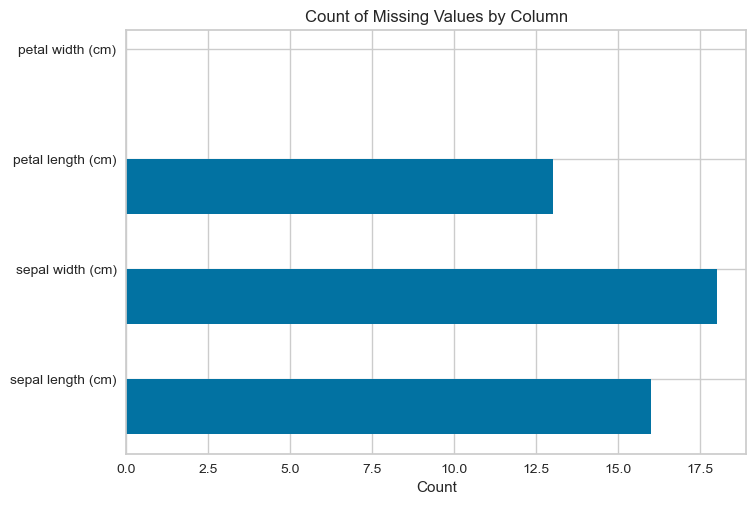

<Axes: title={'center': 'Count of Missing Values by Column'}, xlabel='Count'>

In [9]:
from yellowbrick.contrib.missing import MissingValuesBar
visualizer = MissingValuesBar(features=X_iris_missing.columns)
visualizer.fit(X_iris_missing); visualizer.show()

## Imputación Univariante

Los objetos de tipo *Impute* permite reemplazar los valores nulos. Para ello
pueden usar un valor constante o una estadística (media, mediana o más
frecuente) para cada columna con nulos.


In [10]:
from sklearn.impute import SimpleImputer
# strategy puede ser "mean", "median", "most_frequent", "constant".
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_X = pd.DataFrame(imp.fit_transform(X_iris_missing), columns=X_iris.columns)
print(imputed_X.iloc[:10,:])

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           5.100000          3.500000           1.400000               0.2
1           4.900000          3.060606           1.400000               0.2
2           4.700000          3.200000           1.300000               0.2
3           4.600000          3.100000           1.500000               0.2
4           5.000000          3.600000           1.400000               0.2
5           5.400000          3.900000           1.700000               0.4
6           4.600000          3.400000           1.400000               0.3
7           5.832836          3.400000           1.500000               0.2
8           4.400000          2.900000           3.759124               0.2
9           4.900000          3.100000           1.500000               0.1


## Usando KNN

Se pueden imputar usando el algoritmo de K vecinos (KNN). Para cada atributo
perdido se calcula a partir de los K vecinos más cercanos que no sea nulo. Los
vecinos pueden ser diferentes para cada atributo.

Si no encuentra vecinos sin nulos, el atributo es borrado.

<!-- Missing values can be imputed by the nearest nearest neighbors imputation approach. An euclidean distance metric that supports missing values is used to find the nearest neighbors. Each missing feature is imputed using values from its nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than n_neighbors and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during transform. -->

In [12]:
from sklearn.impute import KNNImputer
Knn_imp = KNNImputer(n_neighbors=4).fit(X_iris_missing)
imputed_X = pd.DataFrame(Knn_imp.transform(X_iris_missing), columns=X_iris.columns)
print(imputed_X.iloc[:10,:])

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0               5.10              3.50              1.400               0.2
1               4.90              3.45              1.400               0.2
2               4.70              3.20              1.300               0.2
3               4.60              3.10              1.500               0.2
4               5.00              3.60              1.400               0.2
5               5.40              3.90              1.700               0.4
6               4.60              3.40              1.400               0.3
7               5.15              3.40              1.500               0.2
8               4.40              2.90              1.375               0.2
9               4.90              3.10              1.500               0.1


# Multiple imputation

## Multiple imputation con regresor lineal (MICE)

Asumiendo que los valores que tenemos en el conjunto de datos provienen de una muestra de una distribución, la aproximación de la imputación múltiple propone realizar varias muestras de la distribución para el valor perdido y luego realizar una agregación (la media, la agregación de varios modelos, etc.)

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr, verbose=2, max_iter=15, tol=1e-10, imputation_order='roman') #se puede usar otro estimador

imputed_X = pd.DataFrame(imp.fit_transform(X_iris_missing), columns=X_iris.columns)
print(imputed_X.iloc[:10,:])

[IterativeImputer] Completing matrix with shape (150, 4)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.01
[IterativeImputer] Change: 2.68655517775566, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.01
[IterativeImputer] Change: 0.6475788532615661, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.02
[IterativeImputer] Change: 0.3710865841111257, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.02
[IterativeImputer] Change: 0.20429844677781617, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.02
[IterativeImputer] Change: 0.104929351587014, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.02
[IterativeImputer] Change: 0.04918309863007697, scaled tolerance: 7.900000000000001e-10 
[IterativeImpu

c:\Users\julian\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Multiple imputation con Random Forest de sklearn

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=rf, verbose=2, max_iter=15, tol=1e-10, imputation_order='roman')

imputed_X = pd.DataFrame(imp.fit_transform(X_iris_missing), columns=X_iris.columns)
print(imputed_X.iloc[:10,:])

[IterativeImputer] Completing matrix with shape (150, 4)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.26
[IterativeImputer] Change: 3.0363538478806986, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.52
[IterativeImputer] Change: 1.1793000000000051, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.76
[IterativeImputer] Change: 0.5329500000000016, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.98
[IterativeImputer] Change: 0.16400000000000237, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 5/15, elapsed time 1.21
[IterativeImputer] Change: 0.45194999999999586, scaled tolerance: 7.900000000000001e-10 
[IterativeImputer] Ending imputation round 6/15, elapsed time 1.44
[IterativeImputer] Change: 0.1666000000000003, scaled tolerance: 7.900000000000001e-10 
[IterativeI

c:\Users\julian\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Visualizando reparto de nulos

También se puede ver la distribución de nulos en las instancias (por ver si hay
instancias con muchos concentrados).

Sklearn permite mostrar visualmente los valores nulos con `MissingIndicator`.

In [15]:
from sklearn.impute import MissingIndicator
indicator = MissingIndicator(missing_values=np.nan).fit(X_iris_missing)
print(indicator.transform(X_iris_missing)[:8,:])
print(indicator.features_)

[[False False False]
 [False  True False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [ True False False]]
[0 1 2]


---

Visualmente se puede mostrar usando `yellobrick`

c:\Users\julian\anaconda3\lib\site-packages\yellowbrick\contrib\missing\dispersion.py:175: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend(loc="upper left", prop={"size": 5}, bbox_to_anchor=(1, 1))


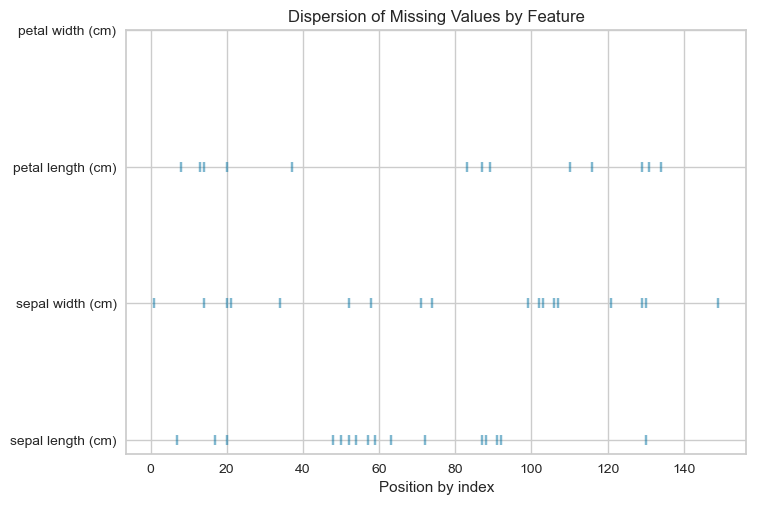

<Axes: title={'center': 'Dispersion of Missing Values by Feature'}, xlabel='Position by index'>

In [16]:
from yellowbrick.contrib.missing import MissingValuesDispersion

visualizer = MissingValuesDispersion(features=X_iris_missing.columns)
visualizer.fit(X_iris_missing)
visualizer.show()

---

La otra opción es cuando se aplique el modelo, añadir el *add_indicator* (falso
por defecto) para que lo muestre.

In [17]:
#Build an Knn imutation object and fit it to the data, setting add_indicator=True
Knn_imp = KNNImputer(n_neighbors=4, add_indicator=True).fit(X_iris_missing)
print(X_iris_missing.head(5))
imputed_X = pd.DataFrame(Knn_imp.transform(X_iris_missing))
print(imputed_X.head(5))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               NaN                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
     0     1    2    3    4    5    6
0  5.1  3.50  1.4  0.2  0.0  0.0  0.0
1  4.9  3.45  1.4  0.2  0.0  1.0  0.0
2  4.7  3.20  1.3  0.2  0.0  0.0  0.0
3  4.6  3.10  1.5  0.2  0.0  0.0  0.0
4  5.0  3.60  1.4  0.2  0.0  0.0  0.0


## Biblioteca statsmodels

Vamos a usar la biblioteca statsmodels para realizar imputación múltiple modelando la distribución de los datos, lo que es típico en NMAR.

conda install -c conda-forge statsmodels

In [18]:
from statsmodels.imputation.bayes_mi import BayesGaussMI, MI

# BayesGaussMI asume que las varibles son normales, por lo que vamos a estandarizar primero
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_iris_missing_scaled = scaler.fit_transform(X_iris_missing)
X_iris_missing_scaled = pd.DataFrame(X_iris_missing_scaled, columns=X_iris.columns)

bm = BayesGaussMI(X_iris_missing_scaled) # mean_prior y cov_prior son los parámetros de la distribución a priori, que se asume normal y con los datos estandarizados es N(0,1)

# Ahora imputamos los valores multiples veces, por ejemplo 100
for k in range(100):
    bm.update() #cada llamada a update() imputa un valor y actualiza los parámetros de la distribución
    #imprimir un ejemplo con valor perdido, por ejemplo fila 7 columna 0
    
    print('Iteracion' + str(k) +" --> " + str(bm.data.iloc[7,0]))
    
# Ahora vamos a utilizar la media de los valores imputados como valor final
imputed_X = bm.data.mean(axis=1)
print(imputed_X.head(10))


Iteracion0 --> -0.3340772309799395
Iteracion1 --> -1.1592221011691515
Iteracion2 --> -1.6297584655162969
Iteracion3 --> -0.7925233716892872
Iteracion4 --> -1.1228785411536388
Iteracion5 --> -1.267840032119525
Iteracion6 --> -1.621297783634454
Iteracion7 --> -1.1610072286950248
Iteracion8 --> -0.9341339235850671
Iteracion9 --> -0.9556770795963219
Iteracion10 --> -1.054772652383291
Iteracion11 --> -0.9168655882755052
Iteracion12 --> -1.3958162752130172
Iteracion13 --> -0.6716444821976467
Iteracion14 --> -0.9777891491261392
Iteracion15 --> -1.6779886333766694
Iteracion16 --> -1.0770510088743945
Iteracion17 --> -1.2477404094522546
Iteracion18 --> -0.46245428877349015
Iteracion19 --> -0.6700555496704577
Iteracion20 --> -0.7265089870227317
Iteracion21 --> -0.7955997784270064
Iteracion22 --> -1.3433971786255356
Iteracion23 --> -1.1911278354670352
Iteracion24 --> -0.8179108447445829
Iteracion25 --> -1.2057943831750997
Iteracion26 --> -0.49618597494673056
Iteracion27 --> -0.9234945781164563
Ite

Normalmente no se utliza la media de los valores imputados directamente. En su lugar, se ajusta un modelo por cada versión del conjunto imputado y se utilizan para obtener una decisión agregada (por ejemplo, modelos de clasificación simples que voten la clase final).

In [51]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from statsmodels.imputation.bayes_mi import BayesGaussMI
from sklearn.model_selection import train_test_split
from scipy.stats import mode

# Supongamos que ya tienes X_iris_missing (datos con valores faltantes) y y_true (etiquetas reales)
# Asegúrate de que X_iris_missing sea un DataFrame y tenga una columna 'target' para las etiquetas
# Si no tienes la columna 'target', agrega y_true a tus datos
y_true = iris_dataset.target.copy()
X_iris_missing['target'] = y_true

# Estandarización de datos (excepto la columna 'target')
features = X_iris_missing.drop(columns='target')
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_iris_missing_scaled = pd.DataFrame(features_scaled, columns=features.columns)
X_iris_missing_scaled['target'] = y_true  # Agregar la columna 'target' nuevamente



# **Renombrar columnas para eliminar espacios y caracteres especiales**
X_iris_missing_scaled.rename(columns={
    'sepal length (cm)': 'sepal_length',
    'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length',
    'petal width (cm)': 'petal_width'
}, inplace=True)

# mostrar los datos perdidos de la columna 'sepal_length'
print(X_iris_missing_scaled['sepal_length'].isnull().sum())

# Crear instancia de BayesGaussMI
bayes_imputer = BayesGaussMI(X_iris_missing_scaled)

# Definir funciones para pasar los argumentos y palabras clave al modelo
def model_args_fn(data):
    return ()

def model_kwds_fn(data):
    return {'data': data}

# Crear una lista para almacenar los conjuntos de datos imputados
imputed_datasets = []

# Definir una función de callback para capturar las imputaciones
def save_imputed_data(result):
    # Acceder al conjunto de datos imputado desde result.model.data.frame
    imputed_data = result.model.data.frame.copy()
    imputed_datasets.append(imputed_data)
    return None  # No es necesario devolver nada

mi = MI(
    imp=bayes_imputer,
    model=sm.OLS,
    formula="sepal_length ~ sepal_width + petal_length + petal_width", #si usamos los nombres originales de las columnas, hay problemas con los espacios
    model_args_fn=model_args_fn,
    model_kwds_fn=model_kwds_fn,
    nrep=20
)

# Ejecutar el método fit para realizar las imputaciones y ajustar el modelo
mi_results = mi.fit(results_cb=save_imputed_data)

# Ahora, aplicar SVM a cada uno de los conjuntos de datos imputados
predictions = []
for imputed_df in imputed_datasets:
    X = imputed_df.drop(columns='target')
    y = imputed_df['target'].astype(int)
    svm_model = SVC()
    svm_model.fit(X, y)
    preds = svm_model.predict(X)
    predictions.append(preds)

# Convertir las predicciones en un array numpy
predictions = np.array(predictions)  # Dimensiones: (n_imputaciones, n_muestras)

# Verificar el contenido y la forma de 'predictions'
print('Shape of predictions:', predictions.shape)
print('Predictions array:')
print(predictions)

# Votación por mayoría simple utilizando 'keepdims=True' en 'mode'
final_predictions = mode(predictions, axis=0, keepdims=True).mode[0]

# Alternativamente, utilizar 'numpy.bincount'
# final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# Evaluar las predicciones finales
accuracy = accuracy_score(y_true, final_predictions)
print(f"Exactitud del modelo SVM con votación: {accuracy}")

16
Shape of predictions: (20, 150)
Predictions array:
[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]
Exactitud del modelo SVM con votación: 0.98


## Estimación MICE con statsmodels

Como vimos en sklearn, podemos encadenar las imputaciones para refinar las mismas. En sklearn se utlizaba la clase IterativeImputer. En statsmodels existe la clase MICEData para realizar la misma tarea. Vamos a aprender a usarla (ya que tiene más estimadores y métodos de optimización que sklearn).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.imputation.mice import MICEData
from sklearn.linear_model import LinearRegression

# Cargar el conjunto de datos iris
iris_dataset = load_iris()
X_iris = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
y_true = iris_dataset.target

# Introducir valores faltantes artificialmente
np.random.seed(0)
X_iris_missing = X_iris.copy()
mask = np.random.rand(*X_iris.shape) < 0.1  # 10% de valores faltantes
X_iris_missing = X_iris_missing.mask(mask)

# Agregar la columna 'target' al DataFrame
X_iris_missing['target'] = y_true

# Estandarizar las características (excepto 'target')
features = X_iris_missing.drop(columns='target')
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features_scaled['target'] = X_iris_missing['target']

features_scaled.rename(columns={
    'sepal length (cm)': 'sepal_length',
    'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length',
    'petal width (cm)': 'petal_width'
}, inplace=True)

# Crear instancia de MICEData
data_imp = MICEData(features_scaled)


# Especificar modelos de imputación personalizados (opcional)
# Por ejemplo, para imputar 'sepal_length' utilizando regresión lineal:
# data_imp.set_imputer('sepal_length', sm.OLS)

# Almacenar los conjuntos de datos imputados
imputed_datasets = []

# Realizar imputaciones múltiples (5 por ejemplo)
for _ in range(5):
    data_imp.update_all()  # Actualiza las imputaciones de todas las variables
    imputed_data = data_imp.data.copy()
    imputed_datasets.append(imputed_data)
    
# Almacenar los coeficientes de cada modelo
coefficients = []
intercepts = []

for imputed_data in imputed_datasets:
    # Separar variables predictoras y objetivo
    X = imputed_data.drop(columns='target')
    y = imputed_data['target']
    
    # Ajustar modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    
    # Almacenar los coeficientes y el intercepto
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)

# Convertir las listas a arrays numpy
coefficients = np.array(coefficients)
intercepts = np.array(intercepts)

# Calcular la media de los coeficientes y el intercepto
mean_coefficients = np.mean(coefficients, axis=0)
mean_intercept = np.mean(intercepts)

# Mostrar los coeficientes promedio
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente promedio': mean_coefficients
})

print("Intercepto promedio:", mean_intercept)
print(coef_df)

from sklearn.metrics import accuracy_score

# Como 'target' es una variable categórica, podemos convertirla en enteros para clasificación
accuracy_scores = []

for imputed_data in imputed_datasets:
    X = imputed_data.drop(columns='target')
    y = imputed_data['target'].astype(int)
    
    # Ajustar un modelo de regresión logística para clasificación
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calcular el accuracy
    accuracy = accuracy_score(y, y_pred)
    accuracy_scores.append(accuracy)

# Calcular la media del accuracy
mean_accuracy = np.mean(accuracy_scores)
print(f"Exactitud promedio de los modelos: {mean_accuracy}")


Intercepto promedio: 1.0097287264861479
       Variable  Coeficiente promedio
0  sepal_length             -0.064433
1   sepal_width             -0.011258
2  petal_length              0.352803
3   petal_width              0.491761
Exactitud promedio de los modelos: 0.9693333333333334


# Estimación MICE con MiceForest

Existe un paquete llamado miceforest que realiza imputaicones múltiples con lightgbm y es muy eficiente. 
Se suele utilizar cuando no existe certeza sobre la distribución de los datos y se quiere imputar valores faltantes de manera eficiente y no paramétrica.

In [6]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import miceforest as mf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos iris
iris_dataset = load_iris()
X_iris = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
y_true = iris_dataset.target

# Introducir valores faltantes artificialmente
np.random.seed(0)
X_iris_missing = X_iris.copy()
mask = np.random.rand(*X_iris.shape) < 0.1  # 10% de valores faltantes
X_iris_missing = X_iris_missing.mask(mask)

# Crear un objeto de ImputationKernel para miceforest
kds = mf.ImputationKernel(
    X_iris_missing,
    datasets=5,  # Número de conjuntos de datos imputados que deseas generar
    save_all_iterations=True,
    random_state=0
)


# Ejecutar la imputación múltiple
kds.mice(
    iterations=5,
    verbose=True
)

# Obtener el conjunto de datos imputado de la primera iteración
X_iris_imputed = kds.complete_data(iteration=0)

kds = mf.ImputationKernel(
    X_iris_missing,
    save_all_iterations=True,
    random_state=0
)

kds.mice(
    iterations=5,
    verbose=True
)

# iteration=0: Especifica la iteración de la cual obtener los datos imputados. Puedes elegir entre 0 y iterations - 1.
X_iris_imputed = kds.complete_data(iteration=0)



# Separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_iris_imputed, y_true, test_size=0.2, random_state=0
)

# Entrenar un modelo de Random Forest
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy}")



Initialized logger with name mice 1-5
Dataset 0
1  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
2  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
3  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
4  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
5  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
Dataset 1
1  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
2  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
3  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
4  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
5  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
Dataset 2
1  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
2  | sepal length (cm) | sepal width (cm)

Si deseas aprovechar las imputaciones múltiples para tener en cuenta la incertidumbre de los datos faltantes, puedes repetir el entrenamiento del modelo en cada conjunto de datos imputado y combinar los resultados al estilo Múltiple Imputation.

In [4]:
# Almacenar las predicciones de cada imputación
predictions = []

# Generar predicciones para cada iteración de imputación
for i in range(5):
    X_imputed = kds.complete_data(iteration=i) # tomamos cada generación de imputación
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_true, test_size=0.2, random_state=0
    )
    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)

# Convertir las predicciones en un array numpy
predictions = np.array(predictions)  # Dimensiones: (n_imputaciones, n_muestras)

# Realizar votación por mayoría
from scipy.stats import mode
final_predictions = mode(predictions, axis=0, keepdims=True).mode[0]

# Evaluar las predicciones finales
accuracy = accuracy_score(y_test, final_predictions)
print(f"Exactitud del modelo con votación por mayoría: {accuracy}") #comparar con el 0.93 de la imputación simple anterior


Exactitud del modelo con votación por mayoría: 0.9666666666666667


# Ejercicios

Considera trabajar también con el fichero que guarda registro de pozos de tanzania **tanzania_water_pump_org.csv** (nota: los valores perdidos están representados con cadena vacía) además del iris con valores perdidos artificiales.

A continuación, te proporcionamos la forma de cargar dicho conjunto.

In [ ]:
import pandas as pd
df = pd.read_csv("tanzania_water_pump_org.csv")
df.columns

---

1. Mostrar algún diagrama para mostrar casos de nulos.

2. Eliminar atributos con un número de nulos mayor que el 30%.

3. Mostrar distribución de nulos.

4. Comparar el número de filas eliminando y no eliminando nulos.

5. Eliminar nulos sobre el original aplicando una imputación sencilla (media, etc.).

6. Imputar los nulos sobre el original aplicando el KNN.

7. Realizar un IterativeImputer usando un SVR como imputador base. Comparar con el resultado de IterativeImputer con LR y RF.

8. Cambia la fórmula en la imputación múltiple para imputar otros atributos y pensar qué atributos intervienen (¿la longitu del sépalo influye en la anchura del pétalo por ejemplo?)

9. Comparar los resultados de diferentes imputaciones usando una métrica (MSE, RMSE) con los valores originales del dataset.

10. ¿Qué ocurre si hay variables categóricas? Utilizar una transformación de datos para procesarlos y comprobar el resultado.

